<img src="images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*Relaxation and Decoherence*_ 

For more information about how to use the IBM Q experience (QX), consult the [tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0), or check out the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).
***
### Contributors
Martin Sandberg, Hanhee Paik and Antonio Córcoles

## Introduction

The interaction of quantum systems with their environment imposes certain limits and constrains in the study of their dynamics. The level of isolation of a quantum system dictates the rate at which it can exchange energy with its environment. This means that a quantum system will not hold a particular state for an arbitrary time, but will in general exchange energy with its environment and relax (or excite) to another state with different energy. This brings a trade-off in terms of controlability: a system that does not exchange much energy with the environment will keep its state for longer but it will be more difficult to access and manipulate. 

Interaction with the environment can also result in decoherence, a process that does not result in energy exchange but that transforms quantum coherent states into classical mixed states.

These processes, energy relaxation and decoherence, are typically described by timescales referred to as $T_1$ and $T_2$, respectively.     

In [1]:
#packages we will need
import sys
if sys.version_info < (3,0):
    raise Exception("Please use Python version 3 or greater.")

sys.path.append("../../")

from qiskit import QuantumProgram
import Qconfig
import numpy as np
import qiskit.basicplotter as plt
from scipy.optimize import curve_fit

In [2]:
# function used to fit the exponetial decay
def exp_fit_fun(x,a,tau,c):
    return a * np.exp(-x/tau) + c

In [3]:
# function used to fit the exponetial rise
def exp_t2e_fit_fun(x,a,tau,c):
    return a *(1.0- np.exp(-x/tau)) + c

In [4]:
# function used to fit the decay cosine
def osc_fit_fun(x,a,tau,f,phi,c):
    return a * np.exp(-x/tau)*np.cos(2*np.pi*f*x+phi) + c

In [5]:
#function for padding with QId gates
def pad_QId(circuit,N,qr):
    # ciruit to add to, N= number of QId gates to add, qr=qubit reg
    for ii in range(N):
        circuit.iden(qr)
    return circuit    
    

In [6]:
#Device and token settings
device = 'ibmqx2' # the device to run on
#device = 'simulator'
shots = 1024    # the number of shots in the experiment 

Q_program = QuantumProgram()
Q_program.set_api(Qconfig.APItoken, Qconfig.config["url"]) # set the APIToken and API url

True

# Measure T1

Let's measure the relaxation time ($T_1$ time) of one of our qubits. In order to do that we simply place the qubit in the excited state (state $|1\rangle$) and measure after some variable delay. The probability of obtaining the state $|1\rangle$ as a function of the delay gives us an exponential whose characteristic time is defined as $T_1$.

We cannot add arbitrary delays currently in the Quantum Experience (will be able to do that soon), and therefore, for now, we just append identity operations after the initial excitation pulse. Each identity operation has the same duration of a single qubit gate time and is followed by a -shorter- buffer time. These parameters are backend-dependent.

In [18]:
# Select qubit to measure T1 on
qubit=3

# Creating registers
qr = Q_program.create_quantum_registers("qr", 5)
cr = Q_program.create_classical_registers("cr", 5)

# the delay times are all set in terms of single qubit gates
#so we need to caluclate the time from these parameters

if device is'ibmqx2':
    pulse_length=0.083 #single qubit gate time 
    buffer_length=0.0066 #spacing between pulses
elif device is 'ibmqx3':
    pulse_length=0.08 #single qubit gate time 
    buffer_length=0.01 #spacing between pulses
else:
    #use ibmqx2 parameters
    pulse_length=0.083 #single qubit gate time 
    buffer_length=0.0066 #spacing between pulses
        

steps=10
gates_per_step=80
max_gates=(steps-1)*gates_per_step+1
tot_length=buffer_length+pulse_length
time_per_step=gates_per_step*tot_length
qc_dict={}
for ii in range(steps):
    step_num='step_%s'%(str(ii))
    qc_dict.update({step_num:Q_program.create_circuit(step_num, ["qr"], ["cr"])})
    qc_dict[step_num].x(qr[qubit])
    qc_dict[step_num]=pad_QId(qc_dict[step_num],gates_per_step*ii,qr[qubit])
    qc_dict[step_num].measure(qr[qubit], cr[qubit])

circuits=list(qc_dict)    
#print(Q_program.get_qasms(circuits))

>> quantum_registers created: qr 5
>> classical_registers created: cr 5


In [19]:
# run the program on hardware/simulator
try:
    Q_status=Q_program.execute(circuits, device, shots, wait=20, timeout=600)
    print(Q_status['status'])
except:
    print("Your max number of pulses %s might be too large, try reducing or/and restart kernel"%(max_gates))

running on backend: ibmqx2
status = RUNNING (20 seconds)
status = RUNNING (40 seconds)
COMPLETED


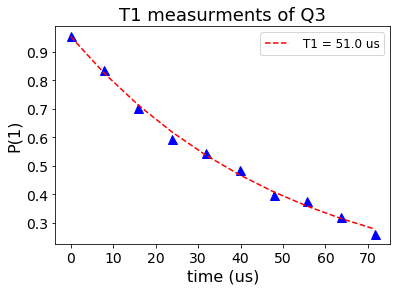

In [20]:
#arrange the data from the run

keys_0_1=list(Q_program.get_counts('step_0').keys())# get the key of the excited state '00001' 

data=np.zeros(len(qc_dict.keys())) # nymphy aray for data
xvals=time_per_step*np.linspace(0,len(qc_dict.keys()),len(qc_dict.keys())) # calculate the time steps 

for ii,key in enumerate(qc_dict.keys()):
    # get the data in terms of counts for the excited state normalized to the total number of counts
    data[ii]=float(Q_program.get_counts(key)[keys_0_1[1]])/shots

#fit the data to an exponetial    
fitT1, fcov = curve_fit(exp_fit_fun, xvals,data,bounds=(0, [1., 100, 0.1])) 
# here we use the qiskit plotter 
plt.plt.plot(xvals,data,marker='^',markersize=9,c='b',linestyle='')
plt.plt.plot(xvals,exp_fit_fun(xvals,*fitT1), c='r',linestyle='--',label=' T1 = %s us'%(str(round(fitT1[1]))))
plt.plt.xticks(fontsize=14)
plt.plt.yticks(fontsize=14)
plt.plt.xlabel('time (us)',fontsize=16)
plt.plt.ylabel('P(1)',fontsize=16)
plt.plt.title('T1 measurments of Q%s'%(str(qubit)),fontsize=18)
plt.plt.legend(fontsize=12)
plt.plt.show()

# Measure T2*

We can also measure the coherence time of our qubits. In order to do this, we place the qubit in a superposition state and let it evolve before measuring it in the $X$-basis. We will see that as time increases, the qubit evolves from a pure superposition state $|\Psi_s\rangle = |0 + 1\rangle$ to a mixture state $|\Psi_m\rangle = |0\rangle + |1\rangle$ with no phase information. 

In the actual experiment we change the phase of the pulse before the measurement in order to create oscillations in the observed dynamics. If we just did two Hadamards gates separated by a delay we would observe a decay of characteristic time $T^*_2$ but with a strong dependence of our calibrated frequency. By implementing the qubit pulses with different phases we shift the frequency dependence into the oscillating feature of the dynamics and can fit the decaying envelope for a more faithful measure of the coherence time.

In [21]:
# Select qubit to measure T2* on
qubit=0


# Creating registers
qr = Q_program.create_quantum_registers("qr", 5)
cr = Q_program.create_classical_registers("cr", 5)


if device is'ibmqx2':
    pulse_length=0.083 #single qubit gate time 
    buffer_length=0.0066 #spacing between pulses
elif device is 'ibmqx3':
    pulse_length=0.08 #single qubit gate time 
    buffer_length=0.01 #spacing between pulses
else:
    #use ibmqx2 parameters
    pulse_length=0.083 #single qubit gate time 
    buffer_length=0.0066 #spacing between pulses


steps=40
gates_per_step=5
max_gates=(steps-1)*gates_per_step+2

num_osc=4
tot_length=buffer_length+pulse_length
time_per_step=gates_per_step*tot_length
f_set=(4.0/(steps*time_per_step)) #set frequency in MHz
qc_dict={}
for ii in range(steps):
    step_num='step_%s'%(str(ii))
    qc_dict.update({step_num:Q_program.create_circuit(step_num, ["qr"], ["cr"])})
    qc_dict[step_num].h(qr[qubit])
    qc_dict[step_num]=pad_QId(qc_dict[step_num],gates_per_step*ii,qr[qubit])
    qc_dict[step_num].u1(2*np.pi*num_osc*ii/(steps-1),qr[qubit])
    qc_dict[step_num].h(qr[qubit])
    qc_dict[step_num].measure(qr[qubit], cr[qubit])
circuits=list(qc_dict)    
#print(Q_program.get_qasms(circuits))

>> quantum_registers created: qr 5
>> classical_registers created: cr 5


In [22]:
# run the program on hardware/simulator
try:
    Q_status=Q_program.execute(circuits, device, shots, wait=20, timeout=600)
    print(Q_status['status'])
except:
    print("Your max number of pulses %s might be too large, try reducing or/and restart kernel"%(max_gates))

running on backend: ibmqx2
status = RUNNING (20 seconds)
status = RUNNING (40 seconds)
status = RUNNING (60 seconds)
status = RUNNING (80 seconds)
COMPLETED


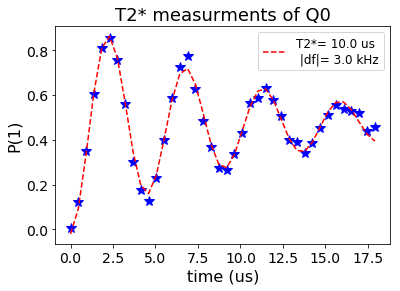

In [23]:
#arrange the data from the run

keys_0_1=list(Q_program.get_counts('step_0').keys())# get the key of the excited state '00001' 

data=np.zeros(len(qc_dict.keys())) # nymphy aray for data
xvals=time_per_step*np.linspace(0,len(qc_dict.keys()),len(qc_dict.keys())) # calculate the time steps 

for ii,key in enumerate(qc_dict.keys()):
    # get the data in terms of counts for the excited state normalized to the total number of counts
    data[ii]=float(Q_program.get_counts(key)[keys_0_1[1]])/shots
    
fitT2s, fcov = curve_fit(osc_fit_fun, xvals,data,bounds=(0, [1., 200, 10*np.pi/xvals[len(xvals)-1],np.pi,1]))

# plot the data and the fit together, here we use the qiskit plotter 
plt.plt.plot(xvals,data,marker='*',markersize=10,c='b',linestyle='')
plt.plt.plot(xvals,osc_fit_fun(xvals,*fitT2s), c='r',linestyle='--',label='T2*= %s us \n |df|= %s kHz'%(str(round(fitT2s[1])),str(round(np.abs((fitT2s[2]-f_set)*1e3)))))
plt.plt.xticks(fontsize=14)
plt.plt.yticks(fontsize=14)
plt.plt.xlabel('time (us)',fontsize=16)
plt.plt.ylabel('P(1)',fontsize=16)
plt.plt.title('T2* measurments of Q%s'%(str(qubit)),fontsize=18)
plt.plt.legend(fontsize=12)
plt.plt.show()


# Measure T2 Echo

We have referred to the previous experiment characteristic time as $T^*_2$ and not $T_2$ by analogy to NMR. Indeed, one can isolate different frequency components to the decoherence process by devising increasingly elaborated pulse sequences. To illustrate the analogy with NMR, one can think about an ensemble of nuclear spins precesing in an external DC magnetic field. Due to field inhomogeneities, each spin might precess with a slightly different Larmoor frequency. This certainly will affect the observed coherence time of the ensemble. However it is possible to echo away this low frequency decoherent process by applying a pi-pulse to the system half-way through the delay. The effect of this pi-pulse is to reverse the direction of the precession of each individual spins due to field inhomogeneities. Thus, the spins that had precessed more now start precessing in the opposite direction faster than the spins that had precessed less and after an equal delay all the spins in the system recover the initial coherence, except for other, higher frequency, decoherence mechanisms.

By running this $T_2$ echo sequence we can therefore remove low frequency components of the decoherence.

In [33]:
# Select qubit to measure T2 echo on
qubit=3

# Creating registers
qr = Q_program.create_quantum_registers("qr", 5)
cr = Q_program.create_classical_registers("cr", 5)



if device is'ibmqx2':
    pulse_length=0.083 #single qubit gate time 
    buffer_length=0.0066 #spacing between pulses
elif device is 'ibmqx3':
    pulse_length=0.08 #single qubit gate time 
    buffer_length=0.01 #spacing between pulses
else:
    #use ibmqx2 parameters
    pulse_length=0.083 #single qubit gate time 
    buffer_length=0.0066 #spacing between pulses

steps=20
gates_per_step=20
tot_length=buffer_length+pulse_length
max_gates=(steps-1)*2*gates_per_step+3
time_per_step=(2*gates_per_step)*tot_length
qc_dict={}
for ii in range(steps):
    step_num='step_%s'%(str(ii))
    qc_dict.update({step_num:Q_program.create_circuit(step_num, ["qr"], ["cr"])})
    qc_dict[step_num].h(qr[qubit])
    qc_dict[step_num]=pad_QId(qc_dict[step_num],gates_per_step*ii,qr[qubit])
    qc_dict[step_num].x(qr[qubit])
    qc_dict[step_num]=pad_QId(qc_dict[step_num],gates_per_step*ii,qr[qubit])
    qc_dict[step_num].h(qr[qubit])
    qc_dict[step_num].measure(qr[qubit], cr[qubit])
circuits=list(qc_dict)    
#print(Q_program.get_qasms(circuits))

>> quantum_registers created: qr 5
>> classical_registers created: cr 5


In [34]:
# run the program on hardware/simulator
try:
    Q_status=Q_program.execute(circuits, device, shots, wait=20, timeout=600)
    print(Q_status['status'])
except:
    print("Your max number of pulses %s might be too large, try reducing or/and restart kernel"%(max_gates))

running on backend: ibmqx2
status = RUNNING (20 seconds)
status = RUNNING (40 seconds)
status = RUNNING (60 seconds)
COMPLETED


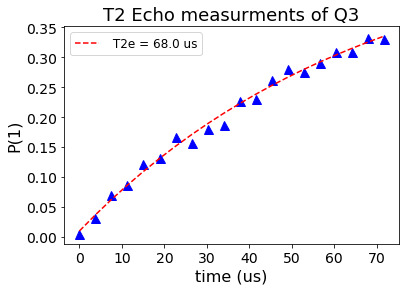

In [35]:
#arrange the data from the run

keys_0_1=list(Q_program.get_counts('step_0').keys())# get the key of the excited state '00001' 

data=np.zeros(len(qc_dict.keys())) # nymphy aray for data
xvals=time_per_step*np.linspace(0,len(qc_dict.keys()),len(qc_dict.keys())) # calculate the time steps 

for ii,key in enumerate(qc_dict.keys()):
    # get the data in terms of counts for the excited state normalized to the total number of counts
    data[ii]=float(Q_program.get_counts(key)[keys_0_1[1]])/shots
    
fitT2e, fcov = curve_fit(exp_t2e_fit_fun, xvals,data,bounds=(0, [0.7, 200, 0.1])) 

# plot the data and the fit together, here we use the qiskit plotter 
plt.plt.plot(xvals,data,marker='^',markersize=9,c='b',linestyle='')
plt.plt.plot(xvals,exp_t2e_fit_fun(xvals,*fitT2e), c='r',linestyle='--',label=' T2e = %s us'%(str(round(fitT2e[1]))))
plt.plt.xticks(fontsize=14)
plt.plt.yticks(fontsize=14)
plt.plt.xlabel('time (us)',fontsize=16)
plt.plt.ylabel('P(1)',fontsize=16)
plt.plt.title('T2 Echo measurments of Q%s'%(str(qubit)),fontsize=18)
plt.plt.legend(fontsize=12)
plt.plt.show()

## Measure CPMG

As explained above, the echo sequence removes low frequency decoherence mechanisms. This noise filtering procedure can be extended with increased number of pi-pulses within the delay. In the following experiment we implement an echo experiment with 7 pi-pulses during the delay between the initial and final pulses. This kind of echo with several pi-pulses is referred to as a CPMG experiment, after Herman Carr, Edward Purcell, Saul Meiboom and Gill.  

In [27]:
# Select qubit to measure T2 echo on
qubit=3

# Creating registers
qr = Q_program.create_quantum_registers("qr", 5)
cr = Q_program.create_classical_registers("cr", 5)



if device is'ibmqx2':
    pulse_length=0.083 #single qubit gate time 
    buffer_length=0.0066 #spacing between pulses
elif device is 'ibmqx3':
    pulse_length=0.08 #single qubit gate time 
    buffer_length=0.01 #spacing between pulses
else:
    #use ibmqx2 parameters
    pulse_length=0.083 #single qubit gate time 
    buffer_length=0.0066 #spacing between pulses

steps=17
gates_per_step=6
num_echo=7 # has to be odd number to end up in ground state at the end
tot_length=buffer_length+pulse_length
time_per_step=((num_echo+1)*gates_per_step+num_echo)*tot_length
max_gates=num_echo*(steps-1)*gates_per_step+num_echo+2
qc_dict={}
for ii in range(steps):
    step_num='step_%s'%(str(ii))
    qc_dict.update({step_num:Q_program.create_circuit(step_num, ["qr"], ["cr"])})
    qc_dict[step_num].h(qr[qubit])
    for iii in range(num_echo):
        qc_dict[step_num]=pad_QId(qc_dict[step_num],gates_per_step*ii,qr[qubit])
        qc_dict[step_num].x(qr[qubit])
    qc_dict[step_num]=pad_QId(qc_dict[step_num],gates_per_step*ii,qr[qubit])
    qc_dict[step_num].h(qr[qubit])
    qc_dict[step_num].measure(qr[qubit], cr[qubit])
circuits=list(qc_dict)    
#print(Q_program.get_qasms(circuits))

>> quantum_registers created: qr 5
>> classical_registers created: cr 5


In [28]:
# run the program on hardware/simulator
try:
    Q_status=Q_program.execute(circuits, device, shots, wait=20, timeout=600)
    print(Q_status['status'])
except:
    print("Your max number of pulses %s might be too large, try reducing or/and restart kernel"%(max_gates))

running on backend: ibmqx2
status = RUNNING (20 seconds)
status = RUNNING (40 seconds)
status = RUNNING (60 seconds)
status = RUNNING (80 seconds)
status = RUNNING (100 seconds)
COMPLETED


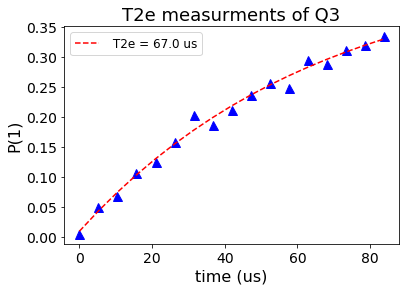

In [29]:
#arrange the data from the run

keys_0_1=list(Q_program.get_counts('step_0').keys())# get the key of the excited state '00001' 

data=np.zeros(len(qc_dict.keys())) # nymphy aray for data
xvals=time_per_step*np.linspace(0,len(qc_dict.keys()),len(qc_dict.keys())) # calculate the time steps 

for ii,key in enumerate(qc_dict.keys()):
    # get the data in terms of counts for the excited state normalized to the total number of counts
    data[ii]=float(Q_program.get_counts(key)[keys_0_1[1]])/shots
    
fitT2e, fcov = curve_fit(exp_t2e_fit_fun, xvals,data,bounds=(0, [0.7, 200, 0.1])) 

# plot the data and the fit together, here we use the qiskit plotter 
plt.plt.plot(xvals,data,marker='^',markersize=9,c='b',linestyle='')
plt.plt.plot(xvals,exp_t2e_fit_fun(xvals,*fitT2e), c='r',linestyle='--',label=' T2e = %s us'%(str(round(fitT2e[1]))))
plt.plt.xticks(fontsize=14)
plt.plt.yticks(fontsize=14)
plt.plt.xlabel('time (us)',fontsize=16)
plt.plt.ylabel('P(1)',fontsize=16)
plt.plt.title('T2e measurments of Q%s'%(str(qubit)),fontsize=18)
plt.plt.legend(fontsize=12)
plt.plt.show()